In [1]:
# Initial packages used for importing, cleaning and visualizing data
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import JSON file
pd.set_option("max_columns",50)
pd.set_option("max_rows",30)
with open('ultimate_data_challenge.json') as f:
    data =  json.load(f)

# Change to DataFrame and fill in missing data
user_data = pd.DataFrame(data)
mean_rating_bydriver = np.mean(user_data['avg_rating_by_driver'])
mean_rating_ofdriver = np.mean(user_data['avg_rating_of_driver'])
user_data.avg_rating_by_driver = user_data.avg_rating_by_driver.replace(np.nan,mean_rating_bydriver,regex=True)
user_data.avg_rating_of_driver = user_data.avg_rating_of_driver.replace(np.nan,mean_rating_ofdriver,regex=True)
user_data.phone.fillna(method='ffill',inplace=True)
user_data['active'] = user_data.last_trip_date > '2014-06-30'

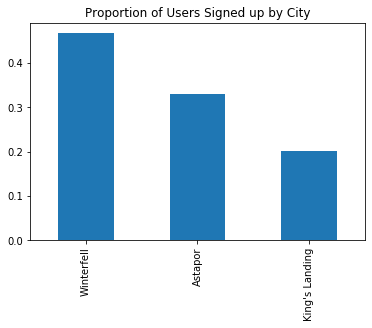

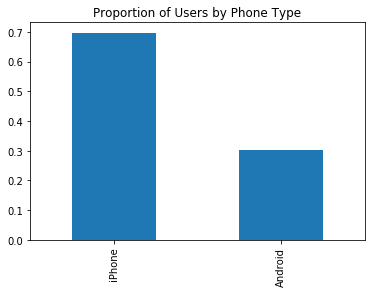

In [2]:
# Plot of users by city
user_data.city.value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Users Signed up by City')
plt.show()

# Plot of % of users with iPhone and Android
user_data.phone.value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Users by Phone Type')
plt.show()

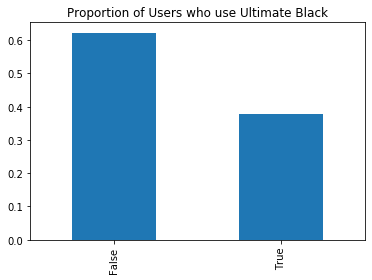

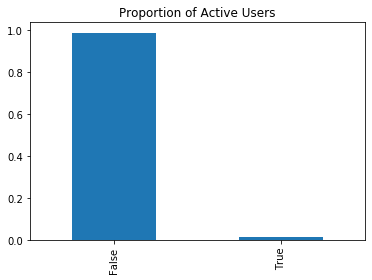

In [3]:
# Plot of % of ultimate black users
user_data.ultimate_black_user.value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Users who use Ultimate Black')
plt.show()

# Plot of % of active users
user_data.active.value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Active Users')
plt.show()

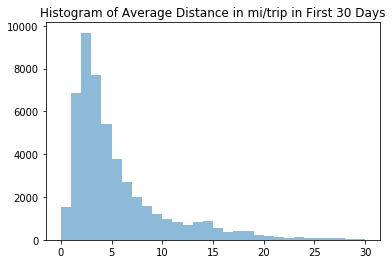

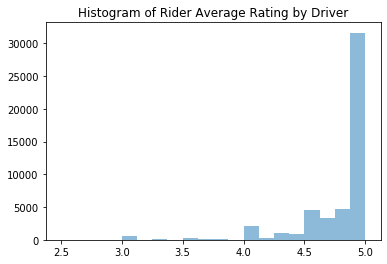

In [4]:
# Histogram of avg_dist
plt.hist(user_data.avg_dist,alpha=0.5,bins=30,range=[0,30])
plt.title('Histogram of Average Distance in mi/trip in First 30 Days')
plt.show()

# Histogram of avg_rating_by_driver
plt.hist(user_data.avg_rating_by_driver,alpha=0.5,bins=20,range=[2.5,5])
plt.title('Histogram of Rider Average Rating by Driver')
plt.show()

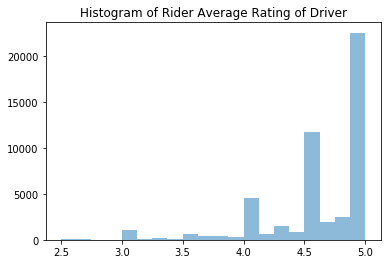

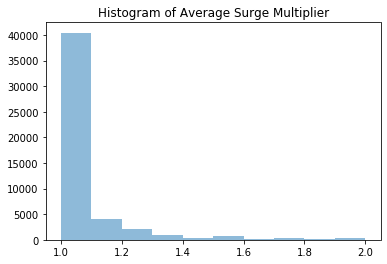

In [5]:
# Histogram of avg_rating_of_driver
plt.hist(user_data.avg_rating_of_driver,alpha=0.5,bins=20,range=[2.5,5])
plt.title('Histogram of Rider Average Rating of Driver')
plt.show()

# Histogram of avg_surge
plt.hist(user_data.avg_surge,alpha=0.5,bins=10,range=[1,2])
plt.title('Histogram of Average Surge Multiplier')
plt.show()

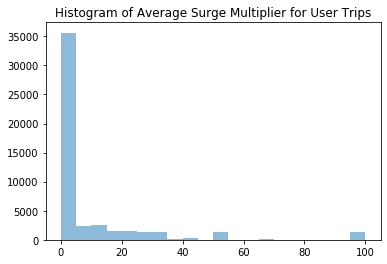

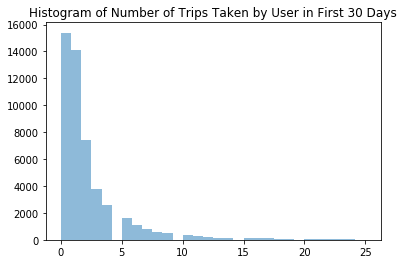

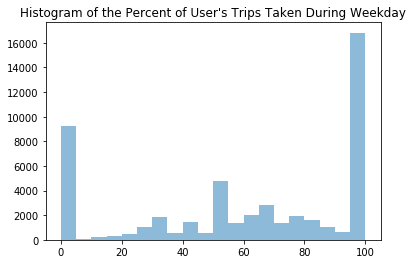

In [6]:
# Histogram of surge_pct
plt.hist(user_data.surge_pct,alpha=0.5,bins=20)
plt.title('Histogram of Average Surge Multiplier for User Trips')
plt.show()

# Histogram of trips_in_first_30_days
plt.hist(user_data.trips_in_first_30_days,alpha=0.5,bins=30,range=[0,25])
plt.title('Histogram of Number of Trips Taken by User in First 30 Days')
plt.show()

# Histogram of weekday_pct
plt.hist(user_data.weekday_pct,alpha=0.5,bins=20)
plt.title("Histogram of the Percent of User's Trips Taken During Weekday")
plt.show()

In [7]:
# Drop date columns, all users signed up in Jan and last trip date implies active or inactive
user_data.drop(['last_trip_date','signup_date'],axis=1,inplace=True)
user_data = pd.get_dummies(user_data)
from sklearn.preprocessing import LabelEncoder

# Encode binary columns as integers
le_ub = LabelEncoder()
user_data.ultimate_black_user = le_ub.fit_transform(user_data.ultimate_black_user)

le_active = LabelEncoder()
user_data.active = le_active.fit_transform(user_data.active)

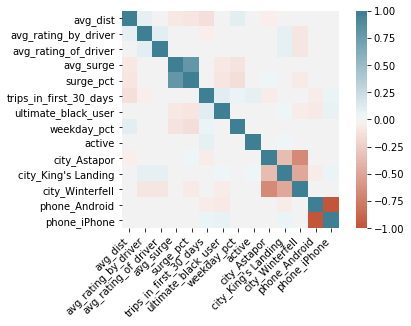

In [8]:
# Heat map plot showing correlation between variables
import seaborn as sns
corr = user_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [9]:
# Import packages used for ML modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler


# set up X and y arrays to be used in sklearn ML algorithms
X = user_data[['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days',
               'ultimate_black_user','weekday_pct','city_Astapor',"city_King's Landing", 'city_Winterfell', 
               'phone_Android', 'phone_iPhone']]
y = user_data['active'].values
y = y.astype(int)

# Set up X and y arrays to be used in Random Undersampling models
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Perform X, y split for dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=42,stratify=y)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=21)

# Perform X, y split for randomundersampled dataset
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=.5,random_state=42,stratify=y_res)

In [10]:
# Collection of functions to make modeling and visualization easier
def fit_model(X_train, y_train, X_test, model):
    '''Fits an ML model and then uses the .predict() method to generate predictions
    for the binary classification as well as associated probabilities and returns those 
    predictions in a tuple'''
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    return (y_pred, y_pred_prob)

def roc_plot(y_test,y_pred_prob,title='ROC Curve'):
    '''Plots the ROC curve associated with classification probabilities
    generated from a ML model'''
    fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1],[0,1],'k--',color='blue')
    plt.plot(fpr,tpr,label='ROC-AUC: %0.2f'%roc_auc_score(y_test, y_pred_prob))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def pr_plot(y_test,y_pred_prob,title='Precision Recall Curve'):
    '''Plots the ROC curve associated with classification probabilities
    generated from a ML model'''
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot([1,0],[0,1],'k--',color='red')
    plt.plot(recall,precision,label='PR AUC: %0.2f'%(auc(recall,precision)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()
    

def model_stats(y_test,y_pred,y_pred_prob, model='Model'):
    '''Outputs summary statistics useful for comparing different ML models and their
    relative performance. Also outputs associated confusion matrix and classification report'''
    print("Tuned {} ROC-AUC score: {:0.2f}".format(model,roc_auc_score(y_test, y_pred_prob)))
    print("Tuned {} Precision Recall AUC score: {:0.2f}".format(model,average_precision_score(y_test, y_pred_prob)))
    print("Accuracy of tuned {}: {:0.2f}".format(model,accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

def model_run_all(X_train,y_train, X_test, y_test, model,model_name='Model'):
    '''Combines ML process into one function by using calls to fit_model(), roc_plot(), pr_plot()
    and model_stats() to provide cohesive ML model analysis'''
    y_pred, y_pred_prob = fit_model(X_train,y_train,X_test,model)
    roc_plot(y_test,y_pred_prob,title="{} ROC Curve".format(model_name))
    pr_plot(y_test,y_pred_prob,title="{} Precision Recall Curve".format(model_name))
    model_stats(y_test, y_pred, y_pred_prob,model=model_name)
    return y_pred, y_pred_prob

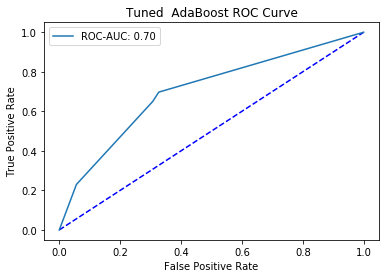

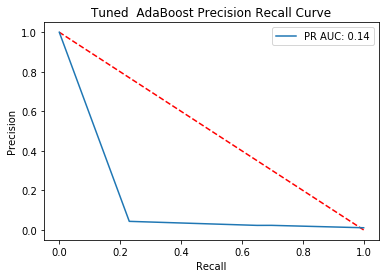

Tuned Tuned  AdaBoost ROC-AUC score: 0.70
Tuned Tuned  AdaBoost Precision Recall AUC score: 0.02
Accuracy of tuned Tuned  AdaBoost: 0.99
[[24726     0]
 [  274     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24726
           1       0.00      0.00      0.00       274

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.98     25000



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
ada_best = AdaBoostClassifier(n_estimators=100, learning_rate=.001, random_state=42)
ada_best_pred, ada_best_pred_prob = model_run_all(X_train, y_train, X_test, y_test, ada_best,'Tuned  AdaBoost')

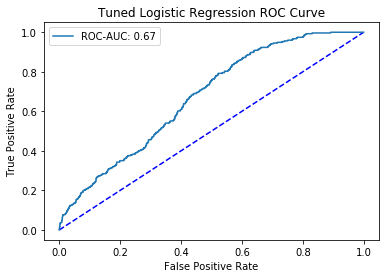

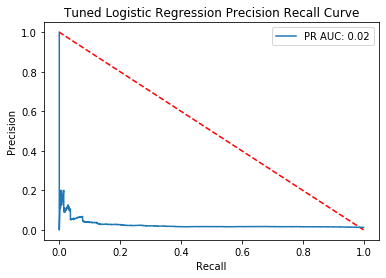

Tuned Tuned Logistic Regression ROC-AUC score: 0.67
Tuned Tuned Logistic Regression Precision Recall AUC score: 0.03
Accuracy of tuned Tuned Logistic Regression: 0.99
[[24726     0]
 [  274     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24726
           1       0.00      0.00      0.00       274

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.98     25000



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
log_reg_best = LogisticRegression(C=.0001,random_state=42)
log_reg_pred, log_reg_pred_prob = model_run_all(X_train, y_train, X_test, y_test, log_reg_best,'Tuned Logistic Regression')

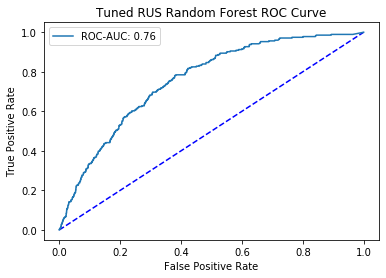

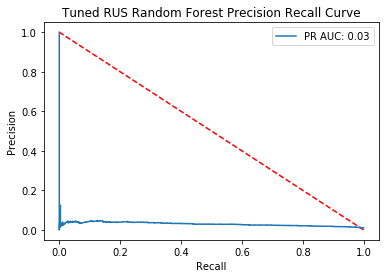

Tuned Tuned RUS Random Forest ROC-AUC score: 0.76
Tuned Tuned RUS Random Forest Precision Recall AUC score: 0.03
Accuracy of tuned Tuned RUS Random Forest: 0.99
[[24726     0]
 [  274     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24726
           1       0.00      0.00      0.00       274

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.98     25000



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
rf_best_cv = RandomForestClassifier(n_estimators=200, min_samples_split=10,min_samples_leaf=4,max_depth=110,
                                    max_features='auto',bootstrap=False,random_state=42)
rf_pred, rf_pred_prob = model_run_all(X_train, y_train, X_test, y_test, rf_best_cv,'Tuned RUS Random Forest')

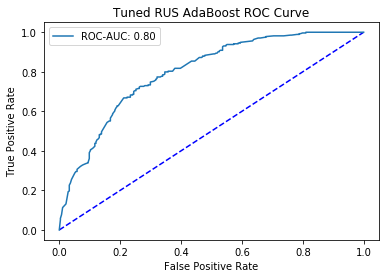

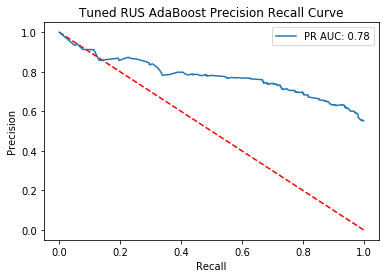

Tuned Tuned RUS AdaBoost ROC-AUC score: 0.80
Tuned Tuned RUS AdaBoost Precision Recall AUC score: 0.77
Accuracy of tuned Tuned RUS AdaBoost: 0.72
[[183  91]
 [ 62 212]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       274
           1       0.70      0.77      0.73       274

    accuracy                           0.72       548
   macro avg       0.72      0.72      0.72       548
weighted avg       0.72      0.72      0.72       548



In [14]:
ada_res_best = AdaBoostClassifier(n_estimators=500, learning_rate=.01, random_state=42)
ada_res_best_pred, ada_res_best_pred_prob = model_run_all(X_res_train, y_res_train, X_res_test, y_res_test, ada_res_best,'Tuned RUS AdaBoost')

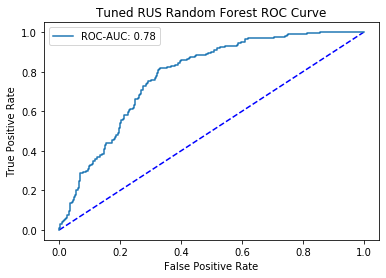

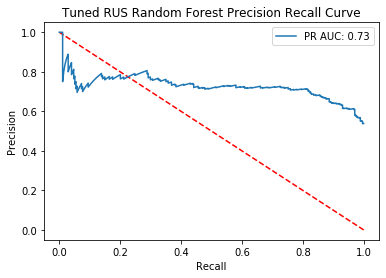

Tuned Tuned RUS Random Forest ROC-AUC score: 0.78
Tuned Tuned RUS Random Forest Precision Recall AUC score: 0.73
Accuracy of tuned Tuned RUS Random Forest: 0.73
[[190  84]
 [ 66 208]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       274
           1       0.71      0.76      0.73       274

    accuracy                           0.73       548
   macro avg       0.73      0.73      0.73       548
weighted avg       0.73      0.73      0.73       548



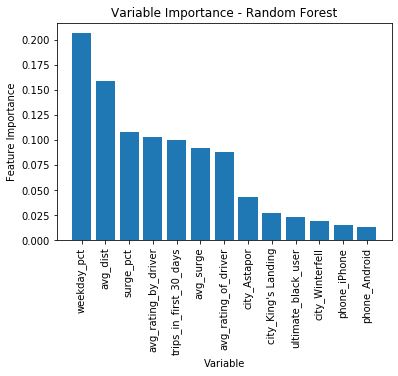

In [15]:
rf_res_best_cv = RandomForestClassifier(n_estimators=200, min_samples_split=5,min_samples_leaf=1,max_depth=36,
                                    max_features='sqrt',bootstrap=True,random_state=42)
rf_res_pred, rf_res_pred_prob = model_run_all(X_res_train, y_res_train, X_res_test, y_res_test, rf_res_best_cv,'Tuned RUS Random Forest')

# extracting feature importances from RF model and storing in DataFrame for plotting
importances = rf_res_best_cv.feature_importances_
importances = pd.Series(importances)
feature_list = list(X_res.columns)
feature_list = pd.Series(feature_list)
feature_importance_df = pd.concat([feature_list, importances],axis=1)
feature_importance_df.columns = ['features','importance']
feature_importance_df = feature_importance_df.sort_values(by='importance',ascending=False)

# plotting feature importances with corresponding labels in bar chart, descending order of importance
plt.bar(list(range((len(importances)))), feature_importance_df['importance'], orientation='vertical')
plt.xticks(list(range((len(importances)))), feature_importance_df['features'], rotation='vertical')
plt.ylabel('Feature Importance')
plt.xlabel('Variable')
plt.title('Variable Importance - Random Forest')
plt.show()

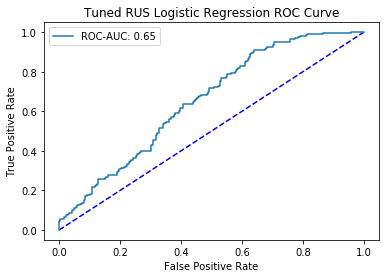

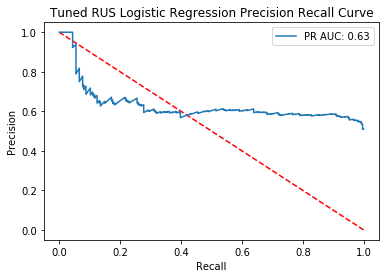

Tuned Tuned RUS Logistic Regression ROC-AUC score: 0.65
Tuned Tuned RUS Logistic Regression Precision Recall AUC score: 0.63
Accuracy of tuned Tuned RUS Logistic Regression: 0.61
[[159 115]
 [ 99 175]]
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       274
           1       0.60      0.64      0.62       274

    accuracy                           0.61       548
   macro avg       0.61      0.61      0.61       548
weighted avg       0.61      0.61      0.61       548



In [16]:
log_reg_res_best = LogisticRegression(C=.001,random_state=42)
log_reg_res_pred, log_reg_res_pred_prob = model_run_all(X_res_train, y_res_train, X_res_test, y_res_test, log_reg_res_best,'Tuned RUS Logistic Regression')

In [17]:
weekday_pct_active = user_data['weekday_pct'][user_data['active'] == 1]
print('Active users have an average weekday percentage use of: {}'.format(np.mean(weekday_pct_active)))
weekday_pct_inactive = user_data['weekday_pct'][user_data['active'] == 0]
print('Active users have an average weekday percentage use of: {}'.format(np.mean(weekday_pct_inactive)))

Active users have an average weekday percentage use of: 70.82682481751826
Active users have an average weekday percentage use of: 60.816369408719076
